## Задача (Sentiment Analysis)

Собраны твиты 2-ух тональностей, необходимо произвести классификацию на 2-а класса.

In [293]:
max_words = 3000
max_len = 15
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [294]:
import pandas as pd

# Загрузка данных
df_train = pd.read_csv('train.csv', encoding='latin-1')
df_val = pd.read_csv('test.csv', encoding='latin-1')

In [295]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


0 - negative<br>
1 - positive

In [296]:
df_train['label'].value_counts().sum()

31962

In [297]:
df_val.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid Ã°ÂÂÂ #hairflip #nev...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [298]:
missing_data = df_train['label'].isnull().sum()
print("Количество отсутствующих значений в столбце 'label':", missing_data)

Количество отсутствующих значений в столбце 'label': 0


### Предобработка

In [299]:
# !pip install nltk

In [300]:
# !pip install spacy && python -m spacy download en_core_web_sm

In [301]:
from string import punctuation
import spacy
import re

In [302]:
puncts = set(punctuation)

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

spaCy не имеет инструмента для стемминга, поскольку в нём отдаётся предпочтение лемматизации

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**позавтракать**<br>
Небыстро, сложно.

In [303]:
nlp = spacy.load('en_core_web_sm')

stop_words = nlp.Defaults.stop_words # Загрузка списка стоп-слов

In [304]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r"'t\s", " not", txt) # Функция re.sub заменяет "'t__" на " not" без пробела.   
    txt = re.sub(r"(\bnot\b)", "\bnot", txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    
    txt = ' '.join([word for word in txt.split() if word.lower() not in stop_words]) # Удаление стоп-слов
    txt = [token.lemma_ for token in nlp(txt)] # Лемматизация слов
    
    return " ".join(txt)

In [305]:
df_train['tweet'].iloc[:2].values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"],
      dtype=object)

In [306]:
df_train['tweet'].iloc[:2].apply(preprocess_text).values

array(['user father dysfunctional selfish drag kid dysfunction run',
       'user user thank lyft credit notuse cause don notoffer wheelchair van pdx disapointe getthanke'],
      dtype=object)

In [307]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|████████████████████████████████████| 17197/17197 [01:00<00:00, 284.04it/s]


In [308]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [309]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /Users/annvorosh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['user', 'father', 'dysfunctional', 'selfish', 'drag']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [310]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [311]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [312]:
tokens_filtered_top[:10]

['user', 'ã', 'love', 'day', 'happy', 'amp', 'i', 'good', 'm', 'time']

In [313]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'ã': 2,
 'love': 3,
 'day': 4,
 'happy': 5,
 'amp': 6,
 'i': 7,
 'good': 8,
 'm': 9,
 'time': 10,
 'life': 11,
 'u': 12,
 'today': 13,
 'like': 14,
 'new': 15,
 'positive': 16,
 'thankful': 17,
 'father': 18,
 'people': 19,
 'go': 20,
 'smile': 21,
 'bihday': 22,
 'get': 23,
 's': 24,
 'work': 25,
 'want': 26,
 'look': 27,
 'come': 28,
 'friend': 29,
 'feel': 30,
 'don': 31,
 'need': 32,
 'weekend': 33,
 'healthy': 34,
 'girl': 35,
 'thank': 36,
 'family': 37,
 'week': 38,
 'fun': 39,
 'way': 40,
 'great': 41,
 'think': 42,
 'find': 43,
 'summer': 44,
 'you': 45,
 'friday': 46,
 '2': 47,
 'bull': 48,
 'year': 49,
 'live': 50,
 'beautiful': 51,
 'thing': 52,
 'know': 53,
 'morning': 54,
 'music': 55,
 'world': 56,
 'home': 57,
 'tomorrow': 58,
 'watch': 59,
 'make': 60,
 'affirmation': 61,
 'fathersday': 62,
 'sad': 63,
 'dad': 64,
 'cute': 65,
 'orlando': 66,
 're': 67,
 'right': 68,
 'blog': 69,
 'night': 70,
 'model': 71,
 'happiness': 72,
 'man': 73,
 'trump': 74,
 'sun

In [314]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [315]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)

In [316]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

CPU times: user 1.98 s, sys: 15.6 ms, total: 2 s
Wall time: 2 s


In [317]:
x_train.shape

(25569, 15)

In [318]:
df_train['tweet'].iloc[0]

'user user user I ve pay attention past year8 year he s ã¢â\x80â ¦'

In [319]:
x_train[0]

array([   1,    1,    1,    7,   78,   81, 1145,  693,   49,  305,   24,
          0,    0,    0,    0])

In [320]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [321]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [322]:
from torch.utils.data import WeightedRandomSampler

# получаем балансировку весов для каждого класса
class_counts = np.bincount(df_train['label'])
class_weights = 1.0 / class_counts

# создаем взвешенный сэмплер
weights = [class_weights[label] for label in df_train['label']]
sampler = WeightedRandomSampler(weights, len(df_train))

# создаем DataLoader с использованием взвешенного сэмплера
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [323]:
# Получаем балансировку весов для каждого класса в валидационном наборе данных
class_counts_test = np.bincount(df_test['label'])
class_weights_test = 1.0 / class_counts_test

# Создаем взвешенный сэмплер для валидационного набора данных
weights_test = [class_weights_test[label] for label in df_test['label']]
sampler_test = WeightedRandomSampler(weights_test, len(df_test))

# Создаем DataLoader с использованием взвешенного сэмплера для валидационного набора данных
test_dataset = DataWrapper(x_test, df_test['label'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [324]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 15])
torch.Size([512])
tensor(0)


In [325]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [326]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(3000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 474497


In [327]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [328]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(test_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/20]. Step [50/50]. Loss: 0.188. Acc: 0.926. Test loss: 0.141. Test acc: 0.929
Epoch [2/20]. Step [50/50]. Loss: 0.135. Acc: 0.948. Test loss: 0.156. Test acc: 0.950
Epoch [3/20]. Step [50/50]. Loss: 0.099. Acc: 0.968. Test loss: 0.165. Test acc: 0.952
Epoch [4/20]. Step [50/50]. Loss: 0.065. Acc: 0.980. Test loss: 0.115. Test acc: 0.954
Epoch [5/20]. Step [50/50]. Loss: 0.032. Acc: 0.986. Test loss: 0.159. Test acc: 0.953
Epoch [6/20]. Step [50/50]. Loss: 0.016. Acc: 0.991. Test loss: 0.294. Test acc: 0.953
Epoch [7/20]. Step [50/50]. Loss: 0.022. Acc: 0.992. Test loss: 0.359. Test acc: 0.947
Epoch [8/20]. Step [50/50]. Loss: 0.034. Acc: 0.994. Test loss: 0.813. Test acc: 0.951
Epoch [9/20]. Step [50/50]. Loss: 0.007. Acc: 0.993. Test loss: 0.185. Test acc: 0.948
Epoch [10/20]. Step [50/50]. Loss: 0.015. Acc: 0.995. Test loss: 0.417. Test acc: 0.948
Epoch [11/20]. Step [50/50]. Loss: 0.018. Acc: 0.997. Test loss: 0.751. Test acc: 0.951
Epoch [12/20]. Step [50/50]. Loss: 0.023.

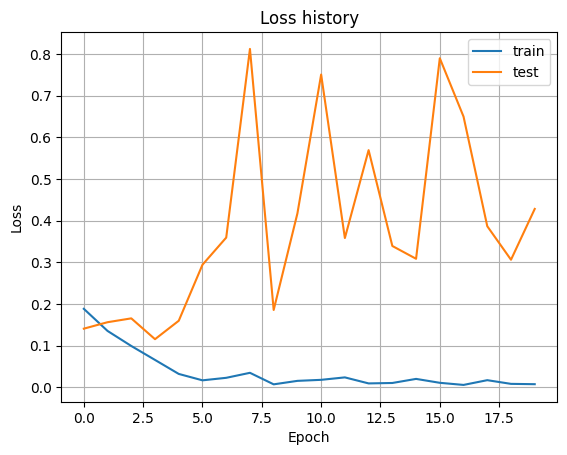

In [329]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

### ВЫВОДЫ:

#### для улучшения результата увеличели количество топовых слов с 2000 до 3000, при этом сократили длину сообщения с 20 до 15 слов. Поработали над балансировкой классов, так как наблюдался большой дисбаланс, подавая взвешенный сэмплер для каждого валидационного набора данных